# The Heuristic Policy
The ```HeuristicPolicy``` suggests all moves that are somewhat 'reasonable'. Not too far a way from the action and ideally on rows or soon-to-be rows with other stones.
Criticality is respected, so that MUST-moves are easily spotted.

In [1]:
import keras.layers
%load_ext autoreload
%autoreload 2

In [86]:
import numpy as np
from aegomoku.tools import print_channels
from aegomoku.utils import analyse_board
from aegomoku.policies.heuristic_policy import HeuristicPolicy
from aegomoku.gomoku_board import GomokuBoard

In [3]:
BOARD_SIZE = 15

In [81]:
stones = "C11F9E9G8F7G7G9H8I8H7I6I9F6H6H9I5J4"
stones = "C11F9E9G8F7G7G9H8I8H7I6I9F6H6H9I5F10J4D8J10C7B6"

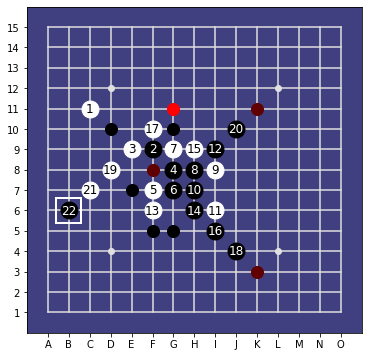

In [82]:
policy = HeuristicPolicy(BOARD_SIZE)
analyse_board(15, stones, policy)

---
# The policy components


## Primary Detector Layer

The primary detector takes the stones and boundary as input and outputs 5 channels. The first three are just projections of the input, the 4th channel identifies critical positions of the current player, and the fifth channel those of the other player.

In [83]:
board = GomokuBoard(BOARD_SIZE, stones=stones)
Move = board.Stone

In [84]:
from aegomoku.policies.primary_detector import PrimaryDetector

detector = PrimaryDetector(BOARD_SIZE)

In [85]:
from keras import layers, activations
activate = layers.Activation(activation=activations.softsign)

In [110]:
from aegomoku.utils import expand

output = detector(expand(board.math_rep))[:, :, :, 3:]
#output = activate(output)[:, :, :, 3:]
#output = np.squeeze(output)
output.shape

TensorShape([1, 17, 17, 2])

### The projected board

In [133]:
import tensorflow as tf
combine = tf.keras.layers.Conv2D(
    name='heuristic_priority',
    filters=1, kernel_size=(1, 1),
    trainable=False,
    activation='relu',
    kernel_initializer=tf.constant_initializer([0., 0., 0., 1., 1.]))


In [134]:
peel = tf.keras.layers.Conv2D(
    filters=1, kernel_size=(3, 3),
    kernel_initializer=tf.constant_initializer([
        [[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]]
    ]),
    bias_initializer=tf.constant_initializer(0.),
    trainable=False)

In [126]:
flatten = tf.keras.layers.Flatten()


[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


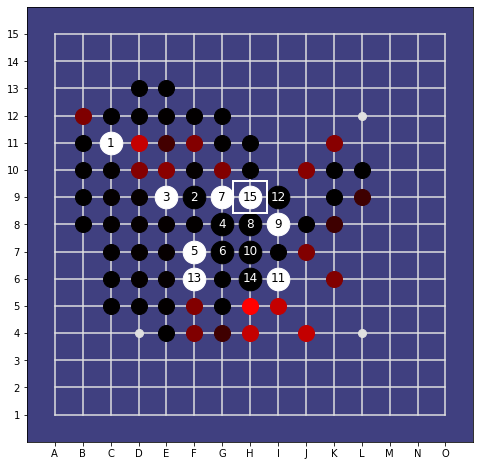

In [150]:
stones = "C11F9E9G8F7G7G9H8I8H7I6I9F6H6H9"
board = GomokuBoard(BOARD_SIZE, stones=stones)
output = detector(expand(board.math_rep))
analyse_board(15, stones, policy, disp_width=8)
#print_channels((output[:, :, :, 3:].numpy()).astype(np.uint))
output = peel(combine(output))
output = tf.keras.activations.tanh(tf.keras.activations.softmax(flatten(output))*100)
print()
print((output.numpy().reshape([15, 15]) ).astype(np.uint)*888)

- I need a primary detector to identify open fours (and maybe open threes as intermediate threats)
- That primary detector output will be added to the topological-value policy, the sum being fed into a softmax. Hence prioretized moves effectively override the soft topoligical policy.
- The topological value makes sense. However, the policy might better equally consider any adjacent and selective next-to-adjacent positions. That's to avoid early bias
- The adviser should be able to further reduce the number of options by providing only options with higher severity than that of the current threat level
- It might suffice to distinguish immediate (open 4) and intermediate (will-be open 4)

## Forward-Looking Layers
Forward-looking layers treat threat positions as potential stones

In [15]:
from aegomoku.policies.forward_looking import ForwardLookingLayer

fwll = ForwardLookingLayer(BOARD_SIZE)

In [16]:
output = detector(board.math_rep)
fwd = np.squeeze(fwll(fwll(output)))

In [17]:
print((fwd[:, :, 3]*100.).astype(int))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 206   0   0   0   0   0   0 206   0   0   0   0   0]
 [  0   0   0   0   0 206   0   0  92   0 206   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  92   0  92   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  92   0 288   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 288   0  92   0   0   0   0]
 [  0   0   0   0   0   0 288 288 488   0 288 288  92   0   0   0   0]
 [  0   0   0   0   0   0  92   0 488   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  92   0 288   0   0   0   0   0   0   0   0   0]
 [  0 

In [16]:
print((fwd[:, :, 4]*100.).astype(int))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 292   0   0  91   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  91   0 284 284 384   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 292  91   0 292   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 284   0   0   0   0]
 [  0   0   0   0   0  91   0   0   0   0   0 284   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 384   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  91   0   0 284 292   0   0   0   0   0]
 [  0   0   0   0   0   0 292   0 284   0 284   0   0   0   0   0   0]
 [  0   0   0   0   0   0 292 284  91  91   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  91   0   0   0  91   0   0   0   0   0   0]
 [  0 

---

# The combined heuristic policy-value function

### TODO: Take this policy into the Arena.ipynb to continue MCTS research!

In [17]:
from aegomoku.policies.heuristic_policy import HeuristicPolicy

# cut_off is used to restrict advice to those positions close enough to the maximum
policy = HeuristicPolicy(BOARD_SIZE, cut_off=.1)

In [18]:
pi = lambda s: policy(s)[0]
v =  lambda s: policy(s)[1]
board.print_pi(pi)
print()
print(v(board.math_rep))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   2   3   4   3   1   0   0   0   0   0   0   0   0]
 [  0 494   4  10  11   8   6   2   0   2   1   2   0   0   0]
 [  0   4   0 771 256 508   9   5   1   3 527   2   1   0   0]
 [  0   7  13 513 537  16 504   5   1 529   5   5   0   0   0]
 [  0   5  15  19   0   0   0   0   0   3   8 239   1   0   0]
 [  0   5  12  20  18  11   0   0   0   8 240   3   0   0   0]
 [  0   3  10  17  21   0   0   0   7 501 251   1   0   0   0]
 [  0   2   6  15  18   0   3   0   0 484 499   0   1   0   0]
 [  0   0   4   8  10 745 251 999   0 488 250   5   0   0   0]
 [  0   0   1   2   5 493 237 760   2   0   6   1   1   0   0]
 [  0   0   0   0   0   0 246   0   0   4   1   1   0   0   0]
 [  0   0   0   0   0 246   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]

tf.Tensor(-0.00461175033262567, shape=(), dtype=float

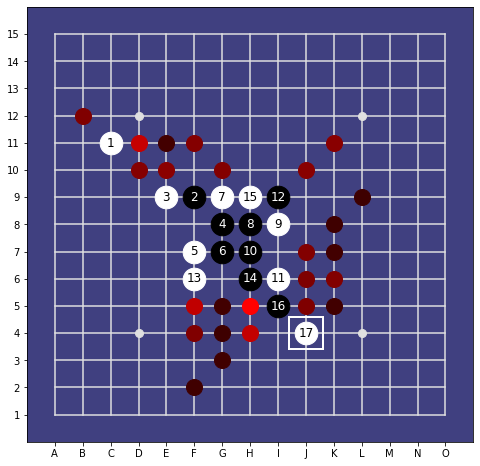

In [19]:
analyse_board(15, stones, policy)

Observe that all critical positions are also *advisable*.

In [20]:
print([Move(a) for a in policy.get_advisable_actions(board.math_rep)])

[B12, D11, E11, F11, K11, D10, E10, G10, J10, L9, K8, J7, K7, J6, K6, F5, G5, H5, J5, K5, F4, G4, H4, G3, F2]


## Super-critical positions

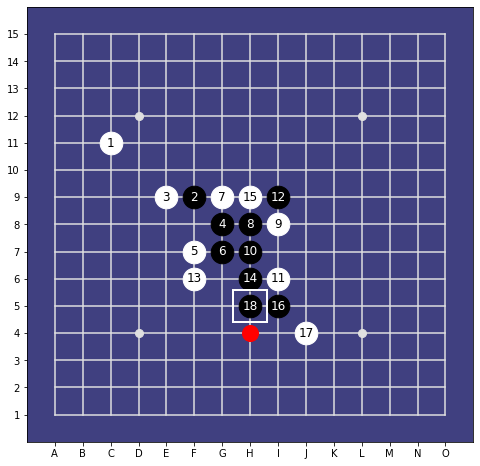

In [21]:
analyse_board(15, stones+"H5", policy)